# Readme

This project originally had three goals:

   **Goal 1:** Use information from a variety of sources to create a database of tokens of one-, two-, and three-word combinations in order to identify what any word's average usage is, as well as how much it varies from that usage.
    
   **Goal 2:** By querying the database, allow users to see what a prospective review's suggested rating would be, as well as identify what word choices are effecting the results.
   
   **Goal 3:** By querying the database, allow users to provide a grouping of reviews that can suggest the overall satisfaction of the product by unifying the reviews and providing an average scoring.  The idea was that this could be done in situations where no pre-provided 5-star system is already in place, such as in book reviews or in data suspected to be biased.  An additional hope would be to provide the most common "unusual" words as a method of providing the user feedback on what reviewers thought were relevant, i.e. "quality", "bent immediately", or "fast service".
   
   > **Only goals 1 and 2 were accomplished.**

This program was **mostly written in Databricks**, where the database itself still lives, using **Spark** and **Python**.  The database is approximately 7gb large, so it is a pain to submit it, reupload it, run it from another source, etc.  It is also, unfortunately, corrupted in certain areas due to Databricks session timeout length when not receiving commands sometimes occurring before a write to the delta lake had completed, ignoring the rest of what was requested to be completed.  On a positive note, this only seems to have effected the averages and variances for the Yelp categories, and the goals of this project seem to be properly completed despite that.

> Link to the Databricks version:  
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3515981017084649/2111837125975741/7760959321468332/latest.html (should be live for 6 months)  
Most of the visualizations had to be removed in order to make the database sharable, due to size constraints.

> Link to separate Databricks documents specifically that will run the visualizations:  
Part 1: https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3515981017084649/1936216346680663/7760959321468332/latest.html  
Part 2: https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3515981017084649/1936216346680716/7760959321468332/latest.html  
Part 3: https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3515981017084649/1936216346680746/7760959321468332/latest.html

**I don't really have the ability to grant any exploration of the database from here** due to the nature of it being a spark delta-table stored in the Databricks dbfs.  With enough elbow grease, the database could be reimported to a known location (ideally one with more resources than a free Databricks account receives) and the appropriate variables altered.

**Data sources are:**

>https://www.kaggle.com/datasets/promptcloud/walmart-product-reviews-dataset?resource=download

>https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews

>https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset?select=yelp_academic_dataset_review.json (required a splitter to be imported to Databricks, ended up being split into 35 parts)

>https://www.kaggle.com/datasets/bittlingmayer/amazonreviews?select=test.ft.txt.bz2 (ended up just being used for testing purposes)

There is a lot here that, if I were to do it again, I would attempt to do it differently.  Loading into the database in the first place ended up taking about a week of continual loading, which I *believe* is caused by me doing it serially and not actually utilizing the main benefits of Spark.  I also ran into a problem where I couldn't make a nested array of tokens like I wanted to, which I did not end up having time to figure out, but which, I suspect, was the main lynchpin to solving my serial vs parallel problem.  Also, database lookup, despite using Spark SQL, is the slowest part of the process of generating stars for the reviews.  This is probably due to the size of the database, but it would be good to experiment with fixing that, since for each review, it currently takes a minute or so to get the results.

# GOAL 1: Database Creation

## Functions for database creation

In [11]:
import re

def tokenize(review):
    tokens = []
    sentences = re.split(r'[!?.]\s+',review)
    for x in range(len(sentences)):
        # break on end of sentence usages
        sentences[x] = re.sub(r'[!\"#\＄&\'\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]+', '', sentences[x], 20, re.MULTILINE)
        # replaces percents with a percent placeholder
        sentences[x] = re.sub(r'[0-9]+\%', '{percent}', sentences[x], 0, re.MULTILINE)
        # replace prices with a price placeholder
        sentences[x] = re.sub(r'\$[0-9]+', '{price}', sentences[x], 0, re.MULTILINE)

        # replaces anything made of numbers and anything else with a numeric placeholder
        sentences[x] = re.sub(r'\S+[0-9]+\S+', '{numeric}', sentences[x],0, re.MULTILINE)
        sentences[x] = re.sub(r'[0-9]+\S+', '{numeric}', sentences[x],0, re.MULTILINE)
        

        
        # Removes any random trailing whitespace, such as in the instance of emojis at the end of a sentence.  I don't know of anyone who write like this, but just being safe.
        sentences[x] = re.sub(r'[ \t]+$','',sentences[x], 0 ,re.MULTILINE)   
        
        # if there are any numbers somehow still there
        sentences[x] = re.sub(r'[0-9]+', '', sentences[x],0, re.MULTILINE)
        sentences[x] = re.sub(r'[!\"#\$%&\'\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]+','',sentences[x], 0 ,re.MULTILINE)
        
    
    for sentence in sentences:
        for x in range(len( words:= re.split(r'\s+', sentence))):
            if words[x] == "" or words [x] == " ":
                break
            # Always add the individual words
            tokens.append(words[x].lower())
            
            # Try adding 3-word and 2-word pairs
            try:
                tokens.append(words[x].lower() + " " + words[x+1].lower() + " " + words[x+2].lower())
                tokens.append(words[x].lower() + " " + words[x+1].lower())
            # Too close to end of sentence
            except:
                # Try adding just the 2-word pairs
                try:
                    tokens.append(words[x].lower() + " " + words[x+1].lower())
                # End of sentence has been reached
                except:
                    break
    return(tokens)

def SaveDeltaTable(dest,file,table, oe):
    try: 
        dbutils.fs.ls(dest+file)
        if oe:
            table.write.format("delta").mode('overwrite').save(dest+file)
            print("Existing file was replaced")
            return
        else:
            print("File already exists")
    except:
        try:
            table.write.format("delta").save(dest+file)
            print("File created")
        except:
            print("\nERROR, NOTHING WAS SAVED!\
            \n I think this error is happening because the schema has been altered in a way that Spark can't understand how to handle.\
            \n Delete the deltaTable and start again to successfully save.")
    return(DeltaTable.forPath(spark, dest+file))


def newAverage(previousCount,previousAverage,addedValue):
    return(
    ( (previousAverage * previousCount) + addedValue ) / (previousCount + 1)
    )
    
def newVariance(previousVariance,previousAverage,previousCount,newAverage,addedValue):
    return(
    (previousVariance*(previousCount) + (addedValue - previousAverage) * (addedValue - newAverage))/(previousCount+1)
    )
    
def batchAverage(previousCount,previousAverage,newCount,newAverage):
    return(
    ((previousAverage * previousCount) + (newAverage * newCount))/(previousCount + newCount)
    )

def batchVariance(previousCount, previousAverage, previousVariance, newCount,newAverage, newVariance):
    finalAverage = batchAverage(previousCount,previousAverage,newCount,newAverage)
    finalVariance = (previousCount * previousVariance 
                   + newCount * newVariance 
                   + previousCount * (previousAverage - finalAverage) ** 2 
                   + newCount * (newAverage - finalAverage) ** 2
                    ) / (previousCount + newCount)
    return(finalVariance)
  
## Used to help iterate through portions of the dataframe, rather than having to hold everything in memory
## Theoretically it eases resource usage, however Spark Delta Lake **writes** are extremely long
def sliceDF(dataframe,grabQuantity):
    index = dataframe.count()
    counter = -1
    ## Gives us our dataframes with the full quantity
    while index > grabQuantity*(counter+1):
        counter += 1
        print('Slice for range: ', grabQuantity*(counter), " , " , grabQuantity*(counter+ 1), " begun.")
        yield dataframe.limit(grabQuantity*(counter+1)).subtract(dataframe.limit(grabQuantity*(counter)))
    ## Gives us the leftover dataframe?
    yield dataframe.subtract(dataframe.limit(grabQuantity*(counter+1)))

    
## Used to update into the Spark Delta Lake.
def mergeData(info,newData):
    info.alias("destination").merge(
        newData.alias("source"),
        "destination.word = source.word"
      ).whenMatchedUpdate(set =
        {
            "TotalCount" : ("destination.TotalCount + source.TotalCount"),
            "TotalAverage": ("(destination.TotalCount*destination.TotalAverage + source.TotalCount*source.TotalAverage)/(destination.TotalCount + source.TotalCount)"),
            # Gross as this looks, it's necessary for calculating variance
            "TotalVariance": ("(( \
                            \
                            (destination.TotalCount * destination.TotalVariance) + \
                            \
                            (source.TotalCount * source.TotalVariance) + \
                            \
                            destination.TotalCount * \
                            (destination.TotalAverage - ((destination.TotalCount*destination.TotalAverage + source.TotalCount*source.TotalAverage)/(destination.TotalCount + source.TotalCount))) \
                            * \
                            (destination.TotalAverage - ((destination.TotalCount*destination.TotalAverage + source.TotalCount*source.TotalAverage)/(destination.TotalCount + source.TotalCount))) \
                            \
                            + \
                            \
                            source.TotalCount * \
                            (source.TotalAverage - ((destination.TotalCount*destination.TotalAverage + source.TotalCount*source.TotalAverage)/(destination.TotalCount + source.TotalCount))) \
                            * \
                            (source.TotalAverage - ((destination.TotalCount*destination.TotalAverage + source.TotalCount*source.TotalAverage)/(destination.TotalCount + source.TotalCount))) \
                            )) \
                            \
                            /(destination.TotalCount + source.TotalCount)"),
            #Amazon Columns
            "YelpCount": ("destination.YelpCount + source.YelpCount"),
            "YelpAverage": ("(destination.YelpCount*destination.YelpAverage + source.YelpCount*source.YelpAverage)/(destination.YelpCount + source.YelpCount)"),
            "YelpVariance": ("(( \
                            \
                            (destination.YelpCount * destination.YelpVariance) + \
                            \
                            (source.YelpCount * source.YelpVariance) + \
                            \
                            destination.YelpCount * \
                            (destination.YelpAverage - ((destination.YelpCount*destination.YelpAverage + source.YelpCount*source.YelpAverage)/(destination.YelpCount + source.YelpCount))) \
                            * \
                            (destination.YelpAverage - ((destination.YelpCount*destination.YelpAverage + source.YelpCount*source.YelpAverage)/(destination.YelpCount + source.YelpCount))) \
                            + \
                            \
                            source.YelpCount * \
                            (source.YelpAverage - ((destination.YelpCount*destination.YelpAverage + source.YelpCount*source.YelpAverage)/(destination.YelpCount + source.YelpCount))) \
                            * \
                            (source.YelpAverage - ((destination.YelpCount*destination.YelpAverage + source.YelpCount*source.YelpAverage)/(destination.YelpCount + source.YelpCount))) \
                            )) \
                            \
                            /(destination.YelpCount + source.YelpCount)"),
            #Walmart Columns
            "WalmartCount": ("destination.WalmartCount + source.WalmartCount"),
            "WalmartAverage": ("(destination.WalmartCount*destination.WalmartAverage + source.WalmartCount*source.WalmartAverage)/(destination.WalmartCount + source.WalmartCount)"),
            "WalmartVariance": ("(( \
                            \
                            (destination.WalmartCount * destination.WalmartVariance) + \
                            \
                            (source.WalmartCount * source.WalmartVariance) + \
                            \
                            destination.WalmartCount * \
                            (destination.WalmartAverage - ((destination.WalmartCount*destination.WalmartAverage + source.WalmartCount*source.WalmartAverage)/(destination.WalmartCount + source.WalmartCount))) \
                            * \
                            (destination.WalmartAverage - ((destination.WalmartCount*destination.WalmartAverage + source.WalmartCount*source.WalmartAverage)/(destination.WalmartCount + source.WalmartCount))) \
                            + \
                            \
                            source.WalmartCount * \
                            (source.WalmartAverage - ((destination.WalmartCount*destination.WalmartAverage + source.WalmartCount*source.WalmartAverage)/(destination.WalmartCount + source.WalmartCount))) \
                            * \
                            (source.WalmartAverage - ((destination.WalmartCount*destination.WalmartAverage + source.WalmartCount*source.WalmartAverage)/(destination.WalmartCount + source.WalmartCount))) \
                            )) \
                            \
                            /(destination.WalmartCount + source.WalmartCount)"),
            #Google Columns
            "GoogleCount": ("destination.GoogleCount + source.GoogleCount"),
            "GoogleAverage": ("(destination.GoogleCount*destination.GoogleAverage + source.GoogleCount*source.GoogleAverage)/(destination.GoogleCount + source.GoogleCount)"),
            "GoogleVariance": ("(( \
                            \
                            (destination.GoogleCount * destination.GoogleVariance) + \
                            \
                            (source.GoogleCount * source.GoogleVariance) + \
                            \
                            destination.GoogleCount * \
                            (destination.GoogleAverage - ((destination.GoogleCount*destination.GoogleAverage + source.GoogleCount*source.GoogleAverage)/(destination.GoogleCount + source.GoogleCount))) \
                            * \
                            (destination.GoogleAverage - ((destination.GoogleCount*destination.GoogleAverage + source.GoogleCount*source.GoogleAverage)/(destination.GoogleCount + source.GoogleCount))) \
                            + \
                            \
                            source.GoogleCount * \
                            (source.GoogleAverage - ((destination.GoogleCount*destination.GoogleAverage + source.GoogleCount*source.GoogleAverage)/(destination.GoogleCount + source.GoogleCount))) \
                            * \
                            (source.GoogleAverage - ((destination.GoogleCount*destination.GoogleAverage + source.GoogleCount*source.GoogleAverage)/(destination.GoogleCount + source.GoogleCount))) \
                            )) \
                            \
                            /(destination.GoogleCount + source.GoogleCount)"),
        }
      ).whenNotMatchedInsertAll(\
      ).execute()
    return

### The function that does most of the work for database creation

In [ ]:
## I *BELIEVE* this is serially calculated.  This is where most of my efforts to parallelize took place.  Ultimately I was
## defeated by data in the format of [rating : {word1: [ave,  rating], word2: [ave, rating], etc}].  Some things that 
## perhaps might've worked had I had time:  explode(), foreach(func), groupByKey(), aggregate(), unioningAll the rows?
## The majority of the code where this might've made sense does not end up appearing here because it did not end up getting
## used, and would just clutter the document


# Takes in string, dataframe
def serializedTokenization(reviewType, data):
    if reviewType == "yelp":
        increment = 3;
    elif reviewType == "walmart":
        increment = 6;
    elif reviewType == "google":
        increment = 9;
        
    Error = []
    dataholder = {}

    # This technically passes it in as an array
    for row in data.collect():
        try:
            for token in tokenize(row.content):
                newStar = row.rating
                ## This is only for the "amazon_test" document, which will not end up in the database
                #if row.rating == "__label__2":
                #    newStar = 5.0
                #if row.rating == "__label__1":
                #    newStar = 1.0               


                if token.lower() in dataholder:         
                    # count
                    dataholder[token.lower()][0] += 1 
                    # average
                    previousAverage = dataholder[token.lower()][1]
                    dataholder[token.lower()][1] = newAverage( dataholder[token.lower()][0] - 1, \
                                                              dataholder[token.lower()][1], \
                                                              newStar )
                    # variance
                    dataholder[token.lower()][2] = newVariance( dataholder[token.lower()][2], \
                                                               previousAverage, \
                                                               dataholder[token.lower()][0]-1, \
                                                               dataholder[token.lower()][1], \
                                                               newStar )

                    # count of interest
                    dataholder[token.lower()][0+increment] += 1
                    # average of interest
                    previousAmazonAverage = dataholder[token.lower()][1+increment]
                    dataholder[token.lower()][1+increment] = newAverage( dataholder[token.lower()][0+increment] - 1, \
                                                                        dataholder[token.lower()][1+increment], \
                                                                        newStar )
                    # variance of interest
                    dataholder[token.lower()][2+increment] = newVariance( dataholder[token.lower()][2+increment], \
                                                                         previousAverage,\
                                                                         dataholder[token.lower()][0+increment]-1, \
                                                                         dataholder[token.lower()][1+increment], \
                                                                         newStar )
                else:
                    # Create a new "default" version for each one
                    dataholder[token.lower()] = [  1,newStar,0.0,  0,0.0,0.0,  0,0.0,0.0,  0,0.0,0.0 ]
                    dataholder[token.lower()][increment] = 1
                    dataholder[token.lower()][increment+1] = newStar
                    # Variance need not be redefined

        except:
            Error.append(row)

    print("Number of Ignored Rows: ", len(Error))
    ## Of all the functions to not work, min?!?  There's a spark version that breaks the regular one
    ## Oh, well, this is solvable using "builtins" which gets called in the visualization chunk later. I learned 
    ## that much later!
    for error in range((lambda s,t: s if s < t else t)(5,len(Error))):
        print("Error ", error+ 1 , " in review: ", Error[error])
    
    spitData = []
    for data in dataholder:
                           # name,  overallCount, overall AveRating, overall 
                    # Total
                    # Yelp
                    # Walmart
                    # Google
        spitData.append([data,\
                         dataholder[data][0],dataholder[data][1],dataholder[data][2],\
                         dataholder[data][3],dataholder[data][4],dataholder[data][5],\
                         dataholder[data][6],dataholder[data][7],dataholder[data][8],\
                         dataholder[data][9],dataholder[data][10],dataholder[data][11]]\
                       )

    newData = spark.createDataFrame(spitData,columns)

    return(newData)

## Database Creation coding

In [ ]:
from delta.tables import *
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Save-relevant stuff
deltaTableDestination = "dbfs:/FileStore/testData/"
fileName = "delta-table"
overwriteExisting = True

# For error checking the tokenizing process
sampleString = "hello, my friend! lovely day to you :) :).80 Can't 'you', \
                the g38, see 380 780f your $3.00 hat is 300% ugly?"

# End structure of the database.  Probably would've been smart to split it into individual databases for each datasource.
columns = StructType([
    StructField("word", StringType(), True),
    StructField("TotalCount", IntegerType(), True),
    StructField("TotalAverage", FloatType(), True),
    StructField("TotalVariance", FloatType(), True),
    StructField("YelpCount", IntegerType(),True),
    StructField("YelpAverage", FloatType(), True),
    StructField("YelpVariance", FloatType(), True),
    StructField("WalmartCount", IntegerType(),True),
    StructField("WalmartAverage", FloatType(), True),
    StructField("WalmartVariance", FloatType(), True),
    StructField("GoogleCount", IntegerType(),True),
    StructField("GoogleAverage", FloatType(), True),
    StructField("GoogleVariance", FloatType(), True)
])

In [ ]:
## Use this for the cleanup of unwanted files
destination = "dbfs:/FileStore/testData/"
fileToRemove = "bungo"  ## if this is left blank, clears the directory, so be careful!
#fileToRemove="delta-table"

try:
    dbutils.fs.ls(destination + fileToRemove) # Determine if the path is a valid one
    dbutils.fs.rm(destination+fileToRemove,True)  # "True" indicates to recursively destroy everything in the directory
    print("File Removed")
    display(dbutils.fs.ls(destination))
except:
    try:
        display(dbutils.fs.ls(destination))
        print("File does not exist.  Here is the directory.")
    except:
        print("Directory does not exist or is empty")


In [ ]:
## Can be used when trying to reset the database/change its formatting.  
## Any other time, this will destroy all work attempted, so is not advised

## DEFAULT/BLANK DATA
#data = [("bungo",\
#         0,0.0,0.0, #Overall \
#         0,0.0,0.0, #Yelp \
#         0,0.0,0.0, #Walmart \
#         0,0.0,0.0) #Google \
#       ]

#StorageTable = spark.createDataFrame(data,columns)

#display(StorageTable)

# Overwrite current DeltaTable state
#SaveDeltaTable(deltaTableDestination,fileName,StorageTable,overwriteExisting)

#Clears out any versions older than a week
#DeltaTable.forPath(spark, deltaTableDestination+fileName).vacuum()

In [ ]:
## This was only ever used for testing purposes.  None of this ever ended up in the finished data.  It did not 
## have a proper star rating provided, only labeled positive/negative sentiment.

# This one is 400k lines long.  It takes 20 mins to parse this thing.  The only way I've gotten it to work consistently 
# is by serializing it, though, defeating some of the purpose of using Spark.
source = "/FileStore/tables/amazon_test.csv"
reviewType = "amazon";

testDF = spark.read.format("csv")\
    .option("sep",",")\
    .load(source)\
    .toDF("rating","content")


display(testDF.take(4))

In [ ]:
# Has 35 parts that need to be loaded from
source = "/FileStore/newFolder/"

yelpDF = spark.read.format("json")\
    .option("sep,",",")\
    .load(source+"*.json")

yelpDF = yelpDF.select(col("stars").cast("float"), "text").toDF("rating","content")

display(yelpDF)

In [ ]:
# Has lots of blank reviews that we could consider dropping, and eventually are during the sorting state.  
# Duplicate rows are removed upon entrance
# Has "NA" ones that are not dropped but probably should be.
source = "dbfs:/FileStore/tables/marketing_sample_for_walmart_com_walmart_product_reviews__20200401_20200630__30k_data.csv"

walmartDF = spark.read.format("csv")\
    .option("sep,",",")\
    .option("header", "true")\
    .load(source)

walmartDF = walmartDF.select(col("Rating").cast("float"),"Review").toDF("rating","content")

display(walmartDF)

In [ ]:
# We have a bunch of ratings that are words for some reason. They should get dropped
# Has 870 reviews with no rating, one of which ALSO has no content
source = "dbfs:/FileStore/tables/reviews.csv"

## The extra options are required to make sure the interpreter doesn't think that "I don't like it's design" 
## randomly has the command 't like it' in it.  It's frustrating, but solvable here.
googleDF = spark.read.format("csv")\
    .option("sep,",",")\
    .option("header", "true")\
    .option("quoteAll", "true")\
    .option("unescapedQuoteHandling","BACK_TO_DELIMITER")\
    .load(source)

googleDF = googleDF.select(col("Score").cast("float"),col("content")).toDF("rating","content")

display(googleDF)

In [ ]:
## Runs each document and saves them to the database.  Each of these was run individually when creating the database

info = DeltaTable.forPath(spark, deltaTableDestination+fileName)

for data in sliceDF(walmartDF,50000):
    newData = serializedTokenization("walmart", data)
    mergeData(info, newData)


for data in sliceDF(googleDF,50000):
    newData = serializedTokenization("google",data)
    mergeData(info, newData)

    

## Hard coding yes, but it'll work which is the important thing.
## 35 total parts, each iteration can completely input about 3 parts in the 2 hour window we have before the 
## cluster shuts itself off.
## This will not run to completion due to the length of the execution of the command
source = "/FileStore/newFolder/"
for x in range(35):
    print("Document ", x+1, ".json begun.")
    yelpDF = spark.read.format("json")\
    .option("sep,",",")\
    .load(source+str(x+1)+".json")

    yelpDF = yelpDF.select(col("stars").cast("float"), "text").toDF("rating","content")

    for data in sliceDF(yelpDF,100000):
        newData = serializedTokenization("yelp",data)
        mergeData(info,newData)

In [ ]:
## Database backup coding

newPath = "dbfs:/FileStore/"
newFileName = "backup"

newInfo.coalesce(1).write.csv(newPath + newFileName)

#Remove previous versions
#dbutils.fs.rm(newPath + newFileName,recurse=True)

backupTest = spark.read.format("csv")\
    .option("sep,",",")\
    .option("header", "true")\
    .load(newPath+newFileName)

display(backupTest)



# Visualization Creation

I use something I call "Reliability" in this section.  Disregard this.  At this point if I try to remove it, I risk breaking the entire program, so I'm leaving it in to stay safe.

## Functions for Visualization Creation

In [ ]:
# This graph can handle about 300k results
import builtins as stat
from random import sample

import plotly
import plotly.express as px
   
def graph(data):
    fig = px.scatter(
        data,
        title="Average vs Variance for Sliced Ranges",
        x=2, # Average
        y=3, # Variance
        # size="County Value",
        color=1,
        template="plotly_dark",
        hover_data={0},
        labels={"0":"words", "1":"Count", "2":"Average", "3":"Variance", "4":"Reliability"}
    )
    fig.show()
    
def d3Graph(data):
    fig = px.scatter_3d(
        data, 
        x=1, 
        y=2, 
        z=3,
        #log_z = True,
        template="plotly_dark",
        hover_data={0},
        color = 4,
        labels={"0":"words", "1":"Count", "2":"Average", "3":"Variance", "4":"Reliability"},
        width=1200,
        height=800
    )
    fig.show()

## Records of how the different visualizations were created

In [ ]:
## Metrics about the total data

query = spark.sql("SELECT AVG(TotalAverage) AS Average,AVG(TotalVariance) as AverageVar,AVG(TotalCount) as AverageCount \
                    FROM delta.`dbfs:/FileStore/testData/delta-table` \
                    WHERE TotalVariance > 0 AND TotalCount > 50").collect()
display(query)

query = spark.sql("SELECT VARIANCE(TotalAverage) AS VarianceOfAverage \
                    FROM delta.`dbfs:/FileStore/testData/delta-table` \
                    WHERE TotalVariance > 0 AND TotalCount > 50").collect()
display(query)

In [ ]:
## Used to illustrate the distribution of averages and variances within the data.  Justifies treating them as skewed normal
## distributions with averages of 3.4 and 1.7 respectively (see query just above this one)

query = spark.sql("\
                  SELECT TotalAverage, TotalVariance\
                  FROM delta.`dbfs:/FileStore/testData/delta-table` \
                  WHERE GoogleAverage > 0 AND GoogleVariance > 0\
                  AND WalmartAverage > 0 AND WalmartVariance > 0\
                  AND TotalCount > 50").collect()
display(query)
                  
fig = px.histogram(
    query,
    x = 0,
    width = 800,
    labels={"0":"Average", "1":"Variance"},
    nbins = 20
)
fig.update_layout(bargap=0.05)
fig.show()

fig = px.histogram(
    query,
    x = 1,
    width = 800,
    labels={"0":"Average", "1":"Variance"},
    nbins = 20
)
fig.update_layout(bargap=0.05)
fig.show()

In [ ]:
## 100 words closest to:

## 1
query = spark.sql("\
                  SELECT word, TotalCount, TotalAverage, TotalVariance, \
                  (ABS(1-TotalAverage)*TotalVariance) AS DistanceScore, \
                  GoogleCount, GoogleAverage, GoogleVariance, \
                  WalmartCount, WalmartAverage, WalmartVariance \
                  \
                  FROM delta.`dbfs:/FileStore/testData/delta-table` \
                  WHERE GoogleAverage > 0 AND GoogleVariance > 0\
                  AND WalmartAverage > 0 AND WalmartVariance > 0\
                  AND TotalCount > 50\
                  ORDER BY TotalAverage ASC\
                  LIMIT 100").collect()
display(query)

## 2
query = spark.sql("\
                  SELECT word,TotalCount,TotalAverage,TotalVariance, \
                  (ABS(2-TotalAverage)*TotalVariance) AS DistanceScore, \
                  GoogleCount, GoogleAverage, GoogleVariance, \
                  WalmartCount, WalmartAverage, WalmartVariance \
                  \
                  FROM delta.`dbfs:/FileStore/testData/delta-table` \
                  WHERE GoogleAverage > 0 AND GoogleVariance > 0\
                  AND WalmartAverage > 0 AND WalmartVariance > 0\
                  AND TotalCount > 50\
                  ORDER BY (ABS(2-TotalAverage)*TotalVariance) ASC\
                  LIMIT 100").collect()
display(query)

## 3
query = spark.sql("\
                  SELECT word, TotalCount, TotalAverage, TotalVariance, \
                  (ABS(3-TotalAverage)*TotalVariance) AS DistanceScore, \
                  GoogleCount, GoogleAverage, GoogleVariance, \
                  WalmartCount, WalmartAverage, WalmartVariance \
                  \
                  FROM delta.`dbfs:/FileStore/testData/delta-table` \
                  WHERE GoogleAverage > 0 AND GoogleVariance > 0\
                  AND WalmartAverage > 0 AND WalmartVariance > 0\
                  AND TotalCount > 50\
                  ORDER BY (ABS(3-TotalAverage)*TotalVariance) ASC\
                  LIMIT 100").collect()
display(query)

## 4
query = spark.sql("\
                  SELECT word, TotalCount, TotalAverage, TotalVariance, \
                  (ABS(4-TotalAverage)*TotalVariance) AS DistanceScore, \
                  GoogleCount, GoogleAverage, GoogleVariance, \
                  WalmartCount, WalmartAverage, WalmartVariance \
                  \
                  FROM delta.`dbfs:/FileStore/testData/delta-table` \
                  WHERE GoogleAverage > 0 AND GoogleVariance > 0\
                  AND WalmartAverage > 0 AND WalmartVariance > 0\
                  AND TotalCount > 50\
                  ORDER BY (ABS(4-TotalAverage)*TotalVariance) ASC\
                  LIMIT 100").collect()
display(query)

## 5
query = spark.sql("\
                  SELECT word, TotalCount, TotalAverage, TotalVariance,\
                  (ABS(5-TotalAverage)*TotalVariance) AS DistanceScore, \
                  GoogleCount, GoogleAverage, GoogleVariance, \
                  WalmartCount, WalmartAverage, WalmartVariance \
                  \
                  FROM delta.`dbfs:/FileStore/testData/delta-table` \
                  WHERE GoogleAverage > 0 AND GoogleVariance > 0\
                  AND WalmartAverage > 0 AND WalmartVariance > 0\
                  AND TotalCount > 50\
                  ORDER BY TotalAverage DESC\
                  LIMIT 100").collect()
display(query)

In [ ]:
## Which Yelp data vary significantly in average from the mean

query = spark.sql(
    "SELECT word, ABS(TotalAverage - YelpAverage) as Difference,(TotalVariance/TotalCount) as Reliability, \
        TotalCount,TotalAverage,TotalVariance,YelpCount, YelpAverage,YelpVariance \
    FROM delta.`dbfs:/FileStore/testData/delta-table` \
    WHERE YelpCount > 50 AND YelpAverage IS NOT NULL AND YelpVariance IS NOT NULL \
        AND ABS(TotalAverage - YelpAverage) > .5 \
    ORDER BY Difference"
    ).collect()

fig = px.scatter_matrix(query,
                        title= "Yelp Factors Compared Against Total Factors",
                        dimensions={1,3,4,5,6,7,8},
                        labels={"0":"words", "1":"Difference", "2":"Reliability", "3":"TotalCount",
                                "4":"TotalAverage","5":"TotalVariance","6":"YelpCount","7":"YelpAverage",
                                "8":"YelpVariance"},
                        width=1200,
                        height=1200,
                        color = 5,
                        hover_data={0}
                        )
fig.show()
display(query)

In [ ]:
## Which Walmart data vary significantly in average from the mean

query = spark.sql(
    "SELECT word, ABS(TotalAverage - WalmartAverage) as Difference,(TotalVariance/TotalCount) as Reliability, \
        TotalCount,TotalAverage,TotalVariance,WalmartCount, WalmartAverage,WalmartVariance \
    FROM delta.`dbfs:/FileStore/testData/delta-table` \
    WHERE WalmartCount > 50 AND WalmartAverage IS NOT NULL AND WalmartVariance IS NOT NULL \
        AND ABS(TotalAverage - WalmartAverage) > .5 \
    ORDER BY Difference"
    ).collect()

fig = px.scatter_matrix(query,
                        title= "Walmart Factors Compared Against Total Factors",
                        dimensions={1,3,4,5,6,7,8},
                        labels={"0":"words", "1":"Difference", "2":"Reliability", "3":"TotalCount", 
                                "4":"TotalAverage","5":"TotalVariance","6":"WalmartCount","7":"WalmartAverage",
                                "8":"WalmartVariance"},
                        width=1200,
                        height=1200,
                        color = 5,
                        hover_data={0}
                        )
fig.show()
display(query)

In [ ]:
## Which Google data vary significantly in average from the mean

query = spark.sql(
    "SELECT word, ABS(TotalAverage - GoogleAverage) as Difference,(TotalVariance/TotalCount) as Reliability, \
        TotalCount,TotalAverage,TotalVariance,GoogleCount, GoogleAverage,GoogleVariance \
    FROM delta.`dbfs:/FileStore/testData/delta-table` \
    WHERE GoogleCount > 50 AND GoogleAverage IS NOT NULL AND GoogleVariance IS NOT NULL \
        AND ABS(TotalAverage - GoogleAverage) > .5 \
    ORDER BY Difference"
    ).collect()


fig = px.scatter_matrix(query,
                        title= "Google Factors Compared Against Total Factors",
                        dimensions={1,3,4,5,6,7,8},
                        labels={"0":"words", "1":"Difference", "2":"Reliability", "3":"TotalCount", 
                                "4":"TotalAverage","5":"TotalVariance","6":"GoogleCount","7":"GoogleAverage",
                                "8":"GoogleVariance"},
                        width=1200,
                        height=1200,
                        color = 5,
                        hover_data={0}
                        )
fig.show()
display(query)

In [ ]:
## Which Google data vary significantly in average from the Walmart data, which are the least represented in our sample

query = spark.sql(
    "SELECT word, ABS(WalmartAverage - GoogleAverage) as Difference,(TotalVariance/TotalCount) as Reliability, \
        WalmartCount,WalmartAverage,WalmartVariance,GoogleCount, GoogleAverage,GoogleVariance,TotalCount \
    FROM delta.`dbfs:/FileStore/testData/delta-table` \
    WHERE GoogleCount > 50 AND GoogleAverage IS NOT NULL AND GoogleVariance IS NOT NULL \
        AND ABS(WalmartAverage - GoogleAverage) > .5 \
        AND WalmartCount > 50 AND WalmartAverage IS NOT NULL AND WalmartVariance IS NOT NULL \
    ORDER BY Difference"
    ).collect()


fig = px.scatter_matrix(query,
                        title= "Google Factors Compared Against Walmart Factors",
                        dimensions={1,3,4,5,6,7,8},
                        labels={"0":"words", "1":"Difference", "2":"Reliability", "3":"WalmartCount", 
                                "4":"WalmartAverage","5":"WalmartVariance","6":"GoogleCount","7":"GoogleAverage",
                                "8":"GoogleVariance","9":"TotalCount"},
                        width=1200,
                        height=1200,
                        color = 9,
                        hover_data={0}
                        )
fig.show()
display(query)

In [ ]:
## Which Yelp data vary significantly in average from the Walmart data

query = spark.sql(
    "SELECT word, ABS(WalmartAverage - YelpAverage) as Difference,(TotalVariance/TotalCount) as Reliability, \
        WalmartCount,WalmartAverage,WalmartVariance,YelpCount, YelpAverage,YelpVariance,TotalCount \
    FROM delta.`dbfs:/FileStore/testData/delta-table` \
    WHERE YelpCount > 50 AND YelpAverage IS NOT NULL AND YelpVariance IS NOT NULL \
        AND ABS(WalmartAverage - YelpAverage) > .5 \
        AND WalmartCount > 50 AND WalmartAverage IS NOT NULL AND WalmartVariance IS NOT NULL \
    ORDER BY Difference"
    ).collect()
        
        

fig = px.scatter_matrix(query,
                        title= "Google Factors Compared Against Walmart Factors",
                        dimensions={1,3,4,5,6,7,8},
                        labels={"0":"words", "1":"Difference", "2":"Reliability", "3":"WalmartCount", 
                                "4":"WalmartAverage","5":"WalmartVariance","6":"YelpCount","7":"YelpAverage",
                                "8":"YelpVariance","9":"TotalCount"},
                        width=1200,
                        height=1200,
                        color = 9,
                        hover_data={0}
                        )
fig.show()
display(query)

In [ ]:
## Which Yelp data vary significantly in average from the Google data, which are the least represented in our sample

query = spark.sql(
    "SELECT word, ABS(GoogleAverage - YelpAverage) as Difference,(TotalVariance/TotalCount) as Reliability, \
        GoogleCount,GoogleAverage,GoogleVariance,YelpCount, YelpAverage,YelpVariance,TotalCount \
    FROM delta.`dbfs:/FileStore/testData/delta-table` \
    WHERE YelpCount > 50 AND YelpAverage IS NOT NULL AND YelpVariance IS NOT NULL \
        AND ABS(GoogleAverage - YelpAverage) > .5 \
        AND GoogleCount > 50 AND GoogleAverage IS NOT NULL AND GoogleVariance IS NOT NULL \
    ORDER BY Difference"
    ).collect()



fig = px.scatter_matrix(query,
                        title= "Yelp Factors Compared Against Google Factors",
                        dimensions={1,3,4,5,6,7,8},
                        labels={"0":"words", "1":"Difference", "2":"Reliability", "3":"GoogleCount", 
                                "4":"GoogleAverage","5":"GoogleVariance","6":"YelpCount","7":"YelpAverage",
                                "8":"YelpVariance","9":"TotalCount"},
                        width=1200,
                        height=1200,
                        color = 9,
                        hover_data={0}
                        )
fig.show()
display(query)

In [ ]:
## Scatter plots that illustrate the distribution of the data average vs variance vs count.  
## Running all of these simultaneously really does a number on your computer's memory!

## Each range was carefully selected to be less than the 300k amount mentioned in the function defintion

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 20000  \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 5000 AND TotalCount < 20000 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 1000 AND TotalCount < 5000 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 500 AND TotalCount < 1000 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 400 AND TotalCount < 500 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 300 AND TotalCount < 400 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 200 AND TotalCount < 300 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 150 AND TotalCount < 200 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 100 AND TotalCount < 150 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 80 AND TotalCount < 100 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 70 AND TotalCount < 80 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 60 AND TotalCount < 70 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
        FROM delta.`dbfs:/FileStore/testData/delta-table` \
        WHERE TotalVariance > 0 AND TotalCount > 50 AND TotalCount < 60 \
        Order By TotalCount ASC LIMIT 300000").collect()
graph(query)

In [ ]:
## A 3D graph to help illustrate the most important metrics against each other

query = spark.sql("SELECT word,TotalCount,TotalAverage,TotalVariance, (TotalVariance/TotalCount) as Reliability \
                    FROM delta.`dbfs:/FileStore/testData/delta-table` \
                    WHERE TotalVariance > 0 AND TotalCount > 50 AND TotalCount < 1000000"
                 ).collect()

sampledData = sorted(sample(query,100000),key=lambda x: x[1] )
d3Graph(sampledData)

# Goal 2:  Visualization of an Individual Review

All data used in this section were produced by querying the database as shown either above or below.  However, Databricks does now allow the importation of .ttf files (fonts), so the visualization code was written in a traditional Jupyter notebook.  It is essentially a "proof of concept" anyway, since Python is really a terrible language for trying to create the visualization.  Something like Java or HTML would've been a lot easier.

In [ ]:
## Loading mechanism.  The destination variables are defined up in the "Database Ceation Coding" subsection

newInfo = spark.read.format("delta").load(deltaTableDestination+fileName)
display(newInfo)

In [19]:
## Constants and functions

from statistics import NormalDist
datasetAve = 3.4295040906981655  ## from the "Records of how the different visualizations were created" subsection
datasetVar = 0.6086397317518185  ## from the "Records of how the different visualizations were created" subsection
distr = NormalDist(datasetAve,datasetVar)
dist2 = NormalDist(3, datasetVar)

## Breaks down results into a dictionary for lookup of token information, since some tokens are used twice
def convert(lst):
    mapp = {}
    for i in range(0, len(lst)):
        mapp[lst[i][0]] = [lst[i][1],lst[i][2],lst[i][3],lst[i][4],lst[i][5]]
    return mapp

## The "return (None)" part of these made the lambda functions a little tricky, so I left them as functions
def averageMap(token,mapp):
    if token in mapp:
        return (mapp[token][1])
    else:
        return(None)
    
def varianceMap(token,mapp):
    if token in mapp:
        return (mapp[token][2])
    else:
        return(None)
    
def weightsMap(token,mapp):
    if token in mapp:
        return (mapp[token][3])
    else:
        return(None)

def weightedAverageMap(token,mapp):
    if token in mapp:
        return (mapp[token][4])
    else:
        return(None)

## Needs to be applied carefully to add any usefulness to our accuracy rating
def scalingValue(numb):
    value = dist2.cdf(numb) * 6
    if value < 1:
        return 1.0
    elif value > 5:
        return 5.0
    else:
        return value

## Does the analysis for what the star of a review should be
def positivity(string):
    tokens = sc.parallelize(tokenize(string))
    tokensList = tokenize(string)
    queryList = "'" + "','".join(tokensList) + "'"

    ## Terribly slow, and I don't think it can do this in parallel.  It could just be that that's why you don't want to 
    ## SQL search a 5gb database
    query = spark.sql("\
                  SELECT word,TotalCount, TotalAverage, TotalVariance,(5 - TotalVariance) AS Weights, \
                      (TotalAverage * (5 - TotalVariance)) AS WeightedAverage\
                  FROM delta.`dbfs:/FileStore/testData/delta-table` \
                  WHERE TotalCount > 50 \
                  AND word IN ({})".format(queryList)).collect()

    keys = convert(query)
    averages = tokens.map(lambda x: averageMap(x,keys))
    tokensCount = averages.filter(lambda x: x != None).count()
    variances = tokens.map(lambda x: varianceMap(x,keys))
    weightedAverages = tokens.map(lambda x: weightedAverageMap(x,keys))
    totalWeights = tokens.map(lambda x: weightsMap(x,keys)).filter(lambda x: x != None).reduce(lambda a,b: a + b)
    
    unweightedAverage = averages.filter(lambda x: x != None).reduce(lambda a,b: a+b) / tokensCount
    weightedAverage = weightedAverages.filter(lambda x: x != None).reduce(lambda a,b: a+b) / totalWeights
    
    
    ## I had better results with this scaling factor acting on the *final* results, rather than each individual token and 
    ## then averaging those.  Technically, this messes up the "how accurate are each token" step of the visualization
    ## process, since if you truly averaged everything you received, you would not receive the same score as what you get
    ## here.
    return(keys, scalingValue(distr.cdf(unweightedAverage)* 4 + 1),scalingValue(distr.cdf(weightedAverage)* 4 + 1))

In [ ]:
## Get a review to analyze
## This is how it *WOULD* be done, if the visualization process were properly linked to the database, which it is not here.

## review = input()

In [ ]:
## A sample testing one for illustration purposes.  The actual rating givne was 3 stars.  Taken from the Yelp dataset.

review = "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. \
        We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ \
        and never had a bad experience. \n \nThe food is good, but it takes a very long time to come out. The \
        waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way \
        too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."
tokens = tokenize(review)
print(tokens)

## Because we cannot run it here, this is what that review would spit out for 
## "keys", "unWeightedScore", and "WeightedScore", respectively!
response ={'done quicker': [126, 3.6190476417541504, 1.870748519897461, 3.129251480102539, 11.324910163879395], 'a': [18487082, 3.553051471710205, 2.1875009536743164, 2.8124990463256836, 9.99295425415039], 'a bad experience': [19880, 3.5278170108795166, 2.6252830028533936, 2.3747169971466064, 8.377567291259766], 'a very': [242755, 3.750155448913574, 1.9935226440429688, 3.0064773559570312, 11.274757385253906], 'about': [1681286, 3.3259363174438477, 2.538477897644043, 2.461522102355957, 8.18686580657959], 'and never': [49561, 2.8623311519622803, 3.0182933807373047, 1.9817066192626953, 5.672300815582275], 'another': [565743, 2.835648536682129, 2.5694468021392822, 2.4305531978607178, 6.892194747924805], 'aware it': [405, 3.1135802268981934, 2.20438289642334, 2.79561710357666, 8.704378128051758], 'bad experience': [30286, 3.0124480724334717, 2.94315242767334, 2.05684757232666, 6.196146488189697], 'be aware': [11700, 3.1740171909332275, 2.308692216873169, 2.691307783126831, 8.542257308959961], 'because i': [210553, 3.057425022125244, 2.544881820678711, 2.455118179321289, 7.5063395500183105], 'come': [845898, 3.4962596893310547, 2.3749725818634033, 2.6250274181365967, 9.177777290344238], 'come out': [60161, 2.9220426082611084, 2.496041774749756, 2.503958225250244, 7.3166728019714355], 'eat here': [64689, 3.620476484298706, 2.431994915008545, 2.568005084991455, 9.297402381896973], 'for another': [40195, 2.921358823776245, 2.6935291290283203, 2.3064708709716797, 6.7380290031433105], 'from beginning': [3864, 4.313146591186523, 1.7699517011642456, 3.230048179626465, 13.931671142578125], 'going to': [339606, 3.1600236892700195, 2.719736099243164, 2.280263900756836, 7.205687999725342], 'good': [3218478, 3.763613224029541, 1.506949543952942, 3.4930505752563477, 13.146491050720215], 'had too': [6500, 3.0461537837982178, 1.733870029449463, 3.266129970550537, 9.94913387298584], 'have been': [487515, 3.3943591117858887, 2.4628818035125732, 2.5371181964874268, 8.611889839172363], 'have just had': [558, 3.2329752445220947, 1.9385541677474976, 3.061445713043213, 9.897578239440918], 'i have': [1014731, 3.5428600311279297, 2.598578691482544, 2.401421308517456, 8.507899284362793], 'if': [2393913, 3.312596082687378, 2.4061739444732666, 2.5938260555267334, 8.592297554016113], 'in order to': [19904, 2.7903435230255127, 2.6406803131103516, 2.3593196868896484, 6.583312511444092], 'is good': [127374, 3.654207229614258, 1.395485281944275, 3.6045145988464355, 13.171643257141113], 'is good but': [18087, 2.9967377185821533, 1.4211760759353638, 3.578824043273926, 10.724797248840332], 'it is': [647560, 3.710636854171753, 1.9356589317321777, 3.0643410682678223, 11.370656967163086], 'it multiple': [600, 2.6549997329711914, 2.3693079948425293, 2.6306920051574707, 6.9844865798950195], 'its other': [298, 3.204698085784912, 1.558769941329956, 3.441230058670044, 11.028103828430176], 'just be aware': [1622, 3.6572132110595703, 1.4928550720214844, 3.5071449279785156, 12.826376914978027], 'locations': [54674, 3.5471339225769043, 2.158082962036133, 2.841917037963867, 10.080659866333008], 'long time': [80238, 3.450871229171753, 2.4199230670928955, 2.5800769329071045, 8.903512954711914], 'long waiting': [782, 3.0703320503234863, 2.3492729663848877, 2.6507270336151123, 8.138611793518066], 'many': [547844, 3.640645980834961, 2.1992173194885254, 2.8007826805114746, 10.19665813446045], 'many experiences': [235, 3.676595687866211, 2.1081759929656982, 2.8918240070343018, 10.632067680358887], 'multiple': [94499, 3.0186879634857178, 2.8795113563537598, 2.1204886436462402, 6.401093482971191], 'opt for': [5911, 3.8935883045196533, 1.221124529838562, 3.7788753509521484, 14.713384628295898], 'or': [1851360, 3.301680326461792, 2.369776964187622, 2.630223035812378, 8.684155464172363], 'other locations in': [918, 3.465141534805298, 2.052706241607666, 2.947293758392334, 10.212790489196777], 'restaurant': [979547, 3.5827488899230957, 2.13249135017395, 2.86750864982605, 10.273563385009766], 'spent way': [539, 2.9740259647369385, 2.4111998081207275, 2.5888001918792725, 7.699159145355225], 'takes a': [11351, 3.5593340396881104, 2.1569716930389404, 2.8430283069610596, 10.119287490844727], 'the waitstaff': [12342, 3.6213741302490234, 1.8129701614379883, 3.1870298385620117, 11.541427612304688], 'time': [2193082, 3.465569019317627, 2.467484474182129, 2.532515525817871, 8.776607513427734], 'time to come': [4470, 3.4360179901123047, 2.265145778656006, 2.734854221343994, 9.397007942199707], 'times because i': [628, 2.883758068084717, 2.2778878211975098, 2.7221121788024902, 7.849913120269775], 'to': [17438564, 3.2881224155426025, 2.5937609672546387, 2.4062390327453613, 7.912008285522461], 'to be done': [10996, 3.0011823177337646, 3.125044107437134, 1.8749558925628662, 5.627084255218506], 'to eat': [269520, 3.5723025798797607, 2.1241276264190674, 2.8758723735809326, 10.273486137390137], 'to eat here': [21768, 3.6185226440429688, 2.2587382793426514, 2.7412617206573486, 9.919317245483398], 'to end': [16223, 3.8837451934814453, 2.1567375659942627, 2.8432624340057373, 11.04250717163086], 'too many experiences': [60, 3.1500000953674316, 1.0941667556762695, 3.9058332443237305, 12.303375244140625], 'tried it': [23818, 3.7257955074310303, 1.8656553030014038, 3.1343445777893066, 11.677927017211914], 'usually opt for': [557, 4.1328535079956055, 0.7148451209068298, 4.285154819488525, 17.709917068481445], 'usually pleasant': [111, 3.2882883548736572, 0.9258989095687866, 4.074100971221924, 13.396819114685059], 'very young': [2063, 2.869607925415039, 2.17543625831604, 2.82456374168396, 8.105390548706055], 'waiting': [274440, 2.643798351287842, 2.514207601547241, 2.485792398452759, 6.571933746337891], 'waitstaff': [23142, 3.5950653553009033, 1.8995918035507202, 3.1004080772399902, 11.146169662475586], 'waitstaff is': [2867, 3.990931272506714, 1.3971967697143555, 3.6028032302856445, 14.3785400390625], 'want to': [346709, 3.2929084300994873, 2.4571444988250732, 2.5428555011749268, 8.373390197753906], 'way': [715399, 3.3108785152435303, 2.4724156856536865, 2.5275843143463135, 8.368524551391602], 'we': [6206395, 3.4079604148864746, 2.4650776386260986, 2.5349223613739014, 8.638915061950684], 'we have': [183205, 3.566469192504883, 2.6807773113250732, 2.3192226886749268, 8.27143669128418], 'we spent': [14618, 3.110685348510742, 2.573190927505493, 2.426809072494507, 7.549039363861084], 'we usually': [12329, 3.9100494384765625, 1.6589548587799072, 3.3410451412200928, 13.063652038574219], 'weekends': [42186, 4.039492130279541, 1.2906699180603027, 3.7093300819396973, 14.983809471130371], 'you decide': [6448, 3.341655969619751, 2.5071847438812256, 2.4928152561187744, 8.330130577087402], 'a very long': [12007, 3.286250114440918, 2.537116050720215, 2.462883949279785, 8.093652725219727], 'and': [25681511, 3.6377549171447754, 2.2880165576934814, 2.7119834423065186, 9.865530967712402], 'been': [1548063, 3.4542605876922607, 2.468540668487549, 2.531459331512451, 8.744319915771484], 'but it takes': [871, 2.9494826793670654, 1.8390095233917236, 3.1609904766082764, 9.323287010192871], 'done': [382294, 3.309819221496582, 2.807082176208496, 2.192917823791504, 7.258161544799805], 'eat here just': [221, 3.22171950340271, 1.7562707662582397, 3.2437291145324707, 10.450385093688965], 'experience': [879810, 3.563694477081299, 2.500797748565674, 2.499202251434326, 8.906393051147461], 'experiences': [61221, 3.354241132736206, 2.649197578430176, 2.350802421569824, 7.885158061981201], 'from': [2067653, 3.4615797996520996, 2.5141429901123047, 2.4858570098876953, 8.604992866516113], 'had a bad': [29186, 4.001678943634033, 1.9985926151275635, 3.0014073848724365, 12.010668754577637], 'have just': [15825, 2.9461610317230225, 2.3982388973236084, 2.6017611026763916, 7.665207386016846], 'here': [2283142, 3.680244207382202, 2.1345882415771484, 2.8654117584228516, 10.545414924621582], 'hours': [261608, 2.985015630722046, 2.8728222846984863, 2.1271777153015137, 6.349658966064453], 'hours from': [2153, 3.1565258502960205, 2.951347589492798, 2.048652410507202, 6.4666242599487305], 'i': [18697064, 3.3454222679138184, 2.5029563903808594, 2.4970436096191406, 8.353665351867676], 'i have been': [162214, 3.7082064151763916, 2.4186415672302246, 2.5813584327697754, 9.572210311889648], 'in nj': [3111, 3.8505303859710693, 2.1020562648773193, 2.8979437351226807, 11.158620834350586], 'is going': [28162, 3.0454158782958984, 2.730165719985962, 2.269834280014038, 6.9125895500183105], 'it takes a': [4987, 3.530379056930542, 2.20015025138855, 2.79984974861145, 9.884531021118164], 'just': [2218874, 3.3068718910217285, 2.3460676670074463, 2.6539323329925537, 8.776214599609375], 'just had': [35904, 3.695493459701538, 2.370816707611084, 2.629183292388916, 9.716129302978516], 'like': [2131330, 3.3827672004699707, 2.1925811767578125, 2.8074188232421875, 9.496844291687012], 'locations in': [5518, 3.7520840167999268, 1.8805458545684814, 3.1194541454315186, 11.70445442199707], 'long': [486317, 3.349078893661499, 2.373755693435669, 2.626244306564331, 8.795499801635742], 'multiple times': [31081, 2.7526140213012695, 2.87014102935791, 2.12985897064209, 5.862679481506348], 'never': [974605, 2.862726926803589, 3.011848211288452, 1.9881517887115479, 5.691535472869873], 'never had': [103411, 3.8495516777038574, 2.1752352714538574, 2.8247647285461426, 10.874077796936035], 'never had a': [38003, 4.032050132751465, 1.93829345703125, 3.06170654296875, 12.344954490661621], 'on the weekends': [18690, 4.118781566619873, 1.1196523904800415, 3.880347728729248, 15.982304573059082], 'or restaurant': [911, 3.129528045654297, 2.2027618885040283, 2.7972381114959717, 8.754034996032715], 'order': [1102274, 3.0469157695770264, 2.4883759021759033, 2.5116240978240967, 7.652707099914551], 'order to': [38170, 2.864081621170044, 2.5764966011047363, 2.4235033988952637, 6.9411115646362305], 'order to be': [3493, 2.508732557296753, 2.2413361072540283, 2.7586638927459717, 6.920750141143799], 'quicker': [7125, 3.457122802734375, 2.0570037364959717, 2.9429962635040283, 10.174299240112305], 'restaurant on the': [3272, 3.871943712234497, 1.699677586555481, 3.3003225326538086, 12.77866268157959], 'take about': [2452, 3.0171291828155518, 2.651419162750244, 2.348580837249756, 7.085971832275391], 'the': [36079061, 3.492626428604126, 2.2600438594818115, 2.7399561405181885, 9.569643020629883], 'the food': [1262533, 3.5931804180145264, 1.9762126207351685, 3.023787498474121, 10.86501407623291], 'the waitstaff is': [2213, 4.006778240203857, 1.3497058153152466, 3.650294303894043, 14.625919342041016], 'the weekends': [20733, 4.112042427062988, 1.1264514923095703, 3.8735485076904297, 15.92819595336914], 'time to': [162883, 3.559542655944824, 2.4323296546936035, 2.5676703453063965, 9.139732360839844], 'times because': [3846, 2.7163288593292236, 2.3805289268493652, 2.6194710731506348, 7.115345001220703], 'too long': [32932, 3.111229181289673, 2.1119747161865234, 2.8880252838134766, 8.985308647155762], 'too long waiting': [83, 2.6626508235931396, 0.89824378490448, 4.1017560958862305, 10.921544075012207], 'too many': [40283, 2.9432764053344727, 2.148484706878662, 2.851515293121338, 8.392797470092773], 'very': [2857285, 3.818835735321045, 1.8700135946273804, 3.12998628616333, 11.952903747558594], 'very long time': [9569, 3.322395086288452, 2.5695905685424805, 2.4304094314575195, 8.074780464172363], 'want': [645106, 3.3375816345214844, 2.4824838638305664, 2.5175161361694336, 8.40241527557373], 'we have just': [347, 3.446685791015625, 2.604506254196167, 2.395493745803833, 8.256514549255371], 'where': [476564, 3.334813356399536, 2.4710326194763184, 2.5289673805236816, 8.433633804321289], 'young': [90287, 3.1503539085388184, 2.6037850379943848, 2.3962149620056152, 7.548925399780273], 'young but': [838, 3.5978519916534424, 2.0089211463928223, 2.9910788536071777, 10.761459350585938], 'about hours': [5016, 3.3464913368225098, 2.7196567058563232, 2.2803432941436768, 7.6311492919921875], 'and never had': [5131, 3.1479241847991943, 2.970322608947754, 2.029677391052246, 6.389270782470703], 'another diner': [426, 3.248826503753662, 1.618836522102356, 3.3811635971069336, 10.984813690185547], 'aware': [31258, 2.8650906085968018, 2.57124924659729, 2.42875075340271, 6.958590984344482], 'bad': [502946, 2.7352564334869385, 2.2681360244750977, 2.7318639755249023, 7.472348690032959], 'be': [3172450, 3.3232955932617188, 2.4812304973602295, 2.5187695026397705, 8.37061595916748], 'be done': [23545, 2.7513699531555176, 2.9861338138580322, 2.0138661861419678, 5.540890693664551], 'because i want': [2376, 3.5492424964904785, 2.2155888080596924, 2.7844111919403076, 9.882550239562988], 'beginning': [32083, 3.3013434410095215, 2.7535035610198975, 2.2464964389801025, 7.41645622253418], 'beginning to': [7112, 3.8876547813415527, 2.345224142074585, 2.654775857925415, 10.320852279663086], 'but': [5354820, 3.4090685844421387, 1.9710716009140015, 3.028928279876709, 10.325823783874512], 'decide': [43656, 3.5205698013305664, 2.3960862159729004, 2.6039137840270996, 9.16726016998291], 'decide to': [13985, 2.8426172733306885, 2.6126997470855713, 2.3873002529144287, 6.7861809730529785], 'diner': [61085, 3.654726982116699, 1.633737325668335, 3.366262674331665, 12.302770614624023], 'diner or': [482, 3.2821574211120605, 1.8788931369781494, 3.1211068630218506, 10.243964195251465], 'end': [226680, 3.3837523460388184, 2.3647639751434326, 2.6352360248565674, 8.916986465454102], 'experiences where': [321, 3.464174509048462, 1.9808034896850586, 3.0191965103149414, 10.459023475646973], 'food': [3519825, 3.6059012413024902, 2.0827555656433105, 2.9172444343566895, 10.519295692443848], 'from beginning to': [3744, 4.343481540679932, 1.6854382753372192, 3.3145618438720703, 14.396738052368164], 'going': [739196, 3.2609455585479736, 2.655959129333496, 2.344040870666504, 7.643789768218994], 'going to take': [5602, 2.5537307262420654, 2.677673578262329, 2.322326421737671, 5.930596351623535], 'had': [4488542, 3.4811923503875732, 2.3813443183898926, 2.6186556816101074, 9.116044044494629], 'had a': [800647, 3.736654281616211, 1.987541675567627, 3.012458324432373, 11.256515502929688], 'have': [4470204, 3.470686674118042, 2.419956922531128, 2.580043077468872, 8.954521179199219], 'have been to': [42359, 3.6635897159576416, 2.2752692699432373, 2.7247307300567627, 9.982295036315918], 'i want to': [50919, 3.5206897258758545, 2.2030274868011475, 2.7969725131988525, 9.847271919250488], 'if you': [856328, 3.6748244762420654, 2.1022541522979736, 2.8977458477020264, 10.648707389831543], 'in nj and': [537, 3.860335111618042, 2.116434335708618, 2.883565664291382, 11.131529808044434], 'is': [8525692, 3.7683205604553223, 2.0045459270477295, 2.9954540729522705, 11.28783130645752], 'is going to': [17140, 3.280163288116455, 2.629444122314453, 2.370555877685547, 7.775810241699219], 'it': [8773909, 3.3907902240753174, 2.2683515548706055, 2.7316484451293945, 9.262446403503418], 'it takes': [24461, 3.078942060470581, 2.5185630321502686, 2.4814369678497314, 7.640200614929199], 'its': [2047834, 3.6682677268981934, 1.9109584093093872, 3.0890417098999023, 11.331432342529297], 'just had too': [209, 3.186602830886841, 1.4149401187896729, 3.585059881210327, 11.424161911010742], 'like it': [118727, 3.1495280265808105, 2.1810061931610107, 2.8189938068389893, 8.878499984741211], 'nj': [13482, 3.7017505168914795, 2.3453304767608643, 2.6546695232391357, 9.826924324035645], 'on': [5044736, 3.417571783065796, 2.3668596744537354, 2.6331403255462646, 8.998946189880371], 'other': [1135675, 3.3570635318756104, 2.264392614364624, 2.735607385635376, 9.183608055114746], 'out': [2471377, 3.3362340927124023, 2.500385284423828, 2.499614715576172, 8.339300155639648], 'spent way too': [330, 2.848484754562378, 2.237649440765381, 2.762350559234619, 7.868513584136963], 'take': [655825, 3.2693066596984863, 2.6544580459594727, 2.3455419540405273, 7.668295860290527], 'takes': [91133, 3.451735258102417, 2.5749504566192627, 2.4250495433807373, 8.37062931060791], 'the food is': [287472, 3.915817975997925, 1.6460484266281128, 3.3539514541625977, 13.133463859558105], 'times': [570988, 3.3013548851013184, 2.4550602436065674, 2.5449397563934326, 8.401749610900879], 'to its': [13658, 3.7186264991760254, 1.8286480903625488, 3.171351909637451, 11.793073654174805], 'to take': [210349, 3.209594488143921, 2.706993579864502, 2.293006420135498, 7.359620571136475], 'usually': [255772, 3.7369375228881836, 1.738243579864502, 3.261756420135498, 12.188980102539062], 'usually opt': [612, 4.13235330581665, 0.7259470224380493, 4.27405309677124, 17.661897659301758], 'waitstaff is very': [374, 4.034759521484375, 1.103069543838501, 3.896930456161499, 15.723176956176758], 'want to like': [3950, 2.3210127353668213, 0.7597358822822571, 4.240263938903809, 9.841706275939941], 'we have tried': [5569, 4.175972938537598, 1.7320064306259155, 3.267993450164795, 13.647051811218262], 'weekends in': [547, 3.954296588897705, 1.535388469696045, 3.464611530303955, 13.700101852416992], 'you decide to': [4187, 3.152376413345337, 2.5619256496429443, 2.4380743503570557, 7.685728073120117], 'a bad': [107969, 3.145134449005127, 2.428713798522949, 2.571286201477051, 8.087040901184082], 'because': [1265006, 3.076416254043579, 2.4726884365081787, 2.5273115634918213, 7.775062561035156], 'been to': [172987, 3.6875603199005127, 2.2173995971679688, 2.7826004028320312, 10.261006355285645], 'beginning to end': [3848, 4.334979057312012, 1.712892770767212, 3.287107229232788, 14.249541282653809], 'but it': [347091, 3.49981427192688, 1.7109946012496948, 3.2890052795410156, 11.510907173156738], 'but usually': [2697, 3.711531400680542, 1.5155991315841675, 3.484400749206543, 12.932462692260742], 'decide to eat': [586, 3.133105993270874, 2.187060832977295, 2.812939167022705, 8.813236236572266], 'eat': [577530, 3.5706093311309814, 2.1801698207855225, 2.8198301792144775, 10.068511962890625], 'food is': [426323, 3.8564913272857666, 1.743459939956665, 3.256540060043335, 12.558818817138672], 'food is good': [36898, 3.3851699829101562, 1.4469069242477417, 3.5530929565429688, 12.027823448181152], 'for': [8514242, 3.4704365730285645, 2.3322231769561768, 2.6677768230438232, 9.258350372314453], 'good but': [191593, 3.2199923992156982, 1.3228278160095215, 3.6771721839904785, 11.840466499328613], 'good but it': [7968, 3.165286064147949, 1.2657278776168823, 3.734272003173828, 11.820038795471191], 'had too many': [1603, 2.857766628265381, 1.8462703227996826, 3.1537296772003174, 9.01262378692627], 'have tried': [36167, 4.008129596710205, 1.821759819984436, 3.1782402992248535, 12.738799095153809], 'have tried it': [1058, 3.5737240314483643, 1.8910678625106812, 3.1089320182800293, 11.110465049743652], 'here just': [7913, 3.7007455825805664, 1.8616665601730347, 3.138333320617676, 11.61417293548584], 'here just be': [124, 3.112902879714966, 1.5517690181732178, 3.4482309818267822, 10.734007835388184], 'i want': [92832, 3.4457945823669434, 2.3587265014648438, 2.6412734985351562, 9.101285934448242], 'if you decide': [3386, 3.139397621154785, 2.5068535804748535, 2.4931464195251465, 7.826977729797363], 'in': [8087804, 3.507051467895508, 2.3854012489318848, 2.6145987510681152, 9.169532775878906], 'in order': [27547, 2.8782806396484375, 2.6304452419281006, 2.3695547580718994, 6.8202433586120605], 'is very': [257474, 4.055842876434326, 1.4868340492248535, 3.5131659507751465, 14.248848915100098], 'it is going': [1346, 3.037146806716919, 2.6464648246765137, 2.3535351753234863, 7.148031711578369], 'it multiple times': [507, 2.731755495071411, 2.464534282684326, 2.535465717315674, 6.926272392272949], 'just be': [17984, 3.4587411880493164, 1.9362424612045288, 3.0637574195861816, 10.5967435836792], 'long time to': [9991, 2.8356523513793945, 1.7880234718322754, 3.2119765281677246, 9.108048439025879], 'multiple times because': [363, 2.382920503616333, 2.1205902099609375, 2.8794097900390625, 6.8614044189453125], 'nj and': [1669, 3.7980825901031494, 2.3121352195739746, 2.6878647804260254, 10.208732604980469], 'on the': [1459452, 3.4247875213623047, 2.225651502609253, 2.774348497390747, 9.501554489135742], 'opt': [8423, 3.779888391494751, 1.4700120687484741, 3.5299878120422363, 13.342960357666016], 'other locations': [11986, 3.252711534500122, 2.186345100402832, 2.813654899597168, 9.152008056640625], 'pleasant': [132664, 3.9609086513519287, 1.5712119340896606, 3.428788185119629, 13.581116676330566], 'restaurant on': [12079, 3.6969947814941406, 2.0052151679992676, 2.9947848320007324, 11.071703910827637], 'spent': [97738, 3.0362703800201416, 2.844180107116699, 2.155819892883301, 6.545651912689209], 'the weekends in': [135, 3.7555556297302246, 1.3550618886947632, 3.6449379920959473, 13.688767433166504], 'to be': [970700, 3.0524957180023193, 2.387901782989502, 2.612098217010498, 7.973418712615967], 'to come': [243927, 3.4106104373931885, 2.5345804691314697, 2.4654195308685303, 8.408585548400879], 'to come out': [26912, 2.7730746269226074, 2.301172971725464, 2.698827028274536, 7.484048843383789], 'to like': [29454, 2.7218375205993652, 1.7790460586547852, 3.220953941345215, 8.766913414001465], 'to like it': [3787, 2.614734172821045, 1.4805643558502197, 3.5194356441497803, 9.202388763427734], 'too': [1038194, 3.656255006790161, 1.8795050382614136, 3.120494842529297, 11.409324645996094], 'tried': [483096, 3.537423610687256, 2.338836908340454, 2.661163091659546, 9.413661003112793], 'very long': [21111, 3.330822706222534, 2.3748538494110107, 2.6251461505889893, 8.743896484375], 'very young but': [99, 3.535353422164917, 1.3194575309753418, 3.680542469024658, 13.012018203735352], 'way too': [52294, 2.760985851287842, 1.7538834810256958, 3.2461166381835938, 8.962482452392578], 'way too long': [4393, 2.5133166313171387, 1.7722446918487549, 3.227755308151245, 8.112371444702148], 'where we': [31806, 3.4769225120544434, 2.366802930831909, 2.633197069168091, 9.15542221069336], 'you': [4856563, 3.647951126098633, 2.277299165725708, 2.722700834274292, 9.932279586791992], 'be aware it': [198, 3.7171716690063477, 1.293745756149292, 3.706254243850708, 13.776782989501953], 'experiences where we': [55, 3.2545454502105713, 0.735206663608551, 4.264793395996094, 13.879963874816895], 'its other locations': [83, 3.25301194190979, 0.9359850287437439, 4.064014911651611, 13.22028923034668], 'diner or restaurant': [52, 3.153846263885498, 0.47633132338523865, 4.5236687660217285, 14.266955375671387], 'where we spent': [168, 3.220238208770752, 1.9931621551513672, 3.006837844848633, 9.682734489440918], 'takes a very': [245, 3.1714279651641846, 1.8644899129867554, 3.135509967803955, 9.94404411315918], 'opt for another': [120, 3.0, 1.0833334922790527, 3.9166665077209473, 11.75], 'to take about': [209, 3.023923397064209, 2.0520589351654053, 2.9479410648345947, 8.914347648620605], 'tried it multiple': [63, 2.682539463043213, 0.6928699612617493, 4.307129859924316, 11.554045677185059], 'we spent way': [104, 2.942307710647583, 1.631286859512329, 3.368713140487671, 9.91179084777832], 'we usually opt': [88, 3.715909004211426, 0.703383207321167, 4.296616554260254, 15.965836524963379], 'about hours from': [132, 3.5151515007019043, 1.598254919052124, 3.401745080947876, 11.957649230957031], 'locations in nj': [56, 3.2857143878936768, 0.8112247586250305, 4.188775062561035, 13.763118743896484], 'take about hours': [152, 2.986842155456543, 2.3550901412963867, 2.6449098587036133, 7.899928092956543], 'aware it is': [135, 3.725925922393799, 1.2656244039535522, 3.734375476837158, 13.914006233215332], 'been to its': [169, 3.597633123397827, 1.625083327293396, 3.3749165534973145, 12.141711235046387], 'is very young': [161, 2.999999761581421, 1.7142854928970337, 3.285714626312256, 9.85714340209961], 'to its other': [59, 3.220339059829712, 0.37517958879470825, 4.624820232391357, 14.893488883972168]}
averages = (2.4850664643198357, 2.679502160796151)

## This is just because I did not have time to make a better "here's how confident we are" score.
averageVariance = 2.03824569215484

## Visualization Function

Creates the visualization. This part would be better made in a different program than Python, if we're being honest. It relies on all of the information in the previous box, as well as tokenize() from the very beginning of the "Functions for database creation" subsection.

The output is organized by:

>a) the tokens that do not show up in the keys, i.e. they have values smaller than 50 in the database, 

>b) the visualization itself, which displays the text, the ranges each scale of token cover (mostly correctly), and a color-scaled visual of what each token does to the review.

This should be more considered a "proof of concept" than anything else.  

### This part will run if the proper functions are loaded.

hours from beginning
nj and never
young but usually
but usually pleasant
many experiences where
for another diner
another diner or
or restaurant on
weekends in order
be done quicker


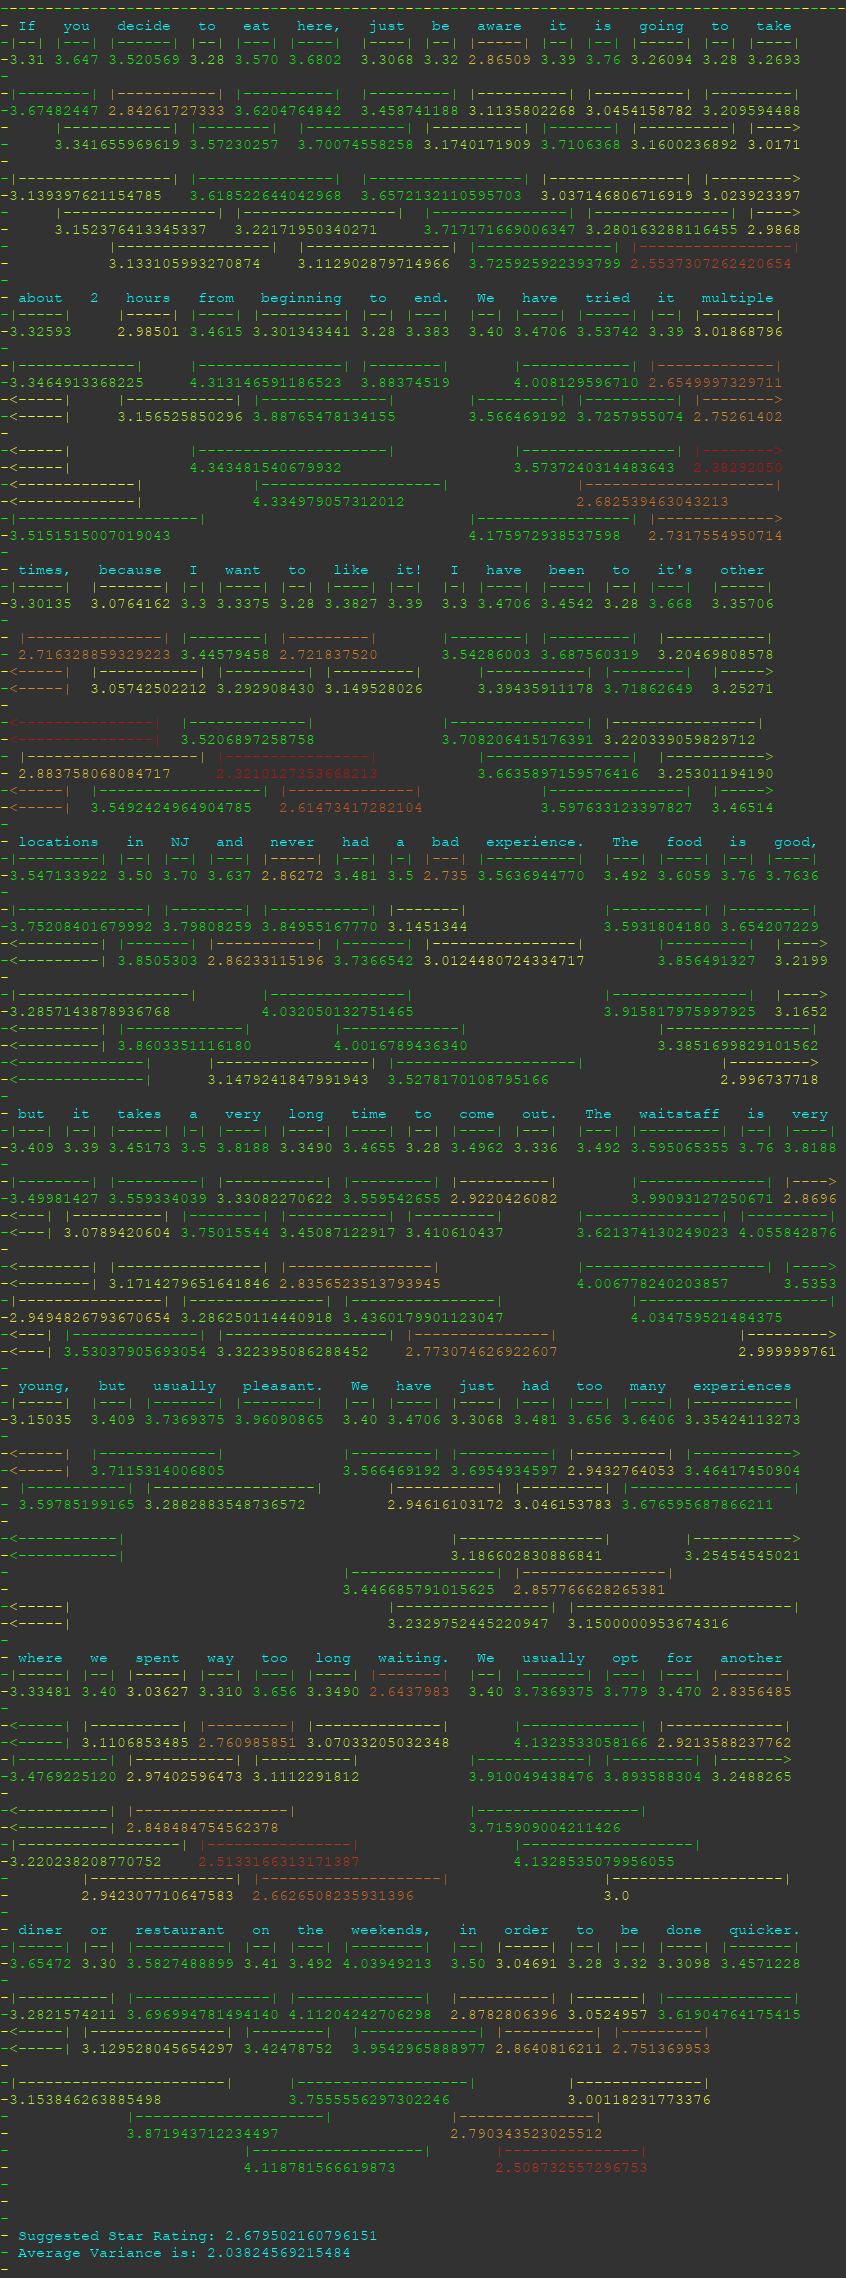

In [18]:
from PIL import Image, ImageDraw, ImageFont

text = review
def splitlines(string, width):
    words = string.split()
    lines = []
    counter = 0
    lineStart = 0
    for i in range(len(words)):
        if (counter + 3 + len(words[i])) > width:
            lines.append("   ".join(words[lineStart:i]));
            counter = len(words[i]);
            lineStart = i
        else:
            counter += len(words[i]) + 3
    #Any words not in a line that "finishes" will get left here.
    lines.append("   ".join(words[lineStart: ]))
    return(lines)

def colormapping(number):
    red = (181, 22, 22)
    yellow = (237, 242, 70)
    green = (14, 237, 18)
    
    ## Since each token is currently contributing to the average in an unscaled manner.
    ## This will not change the number displayed, just the color of the number
    number = scalingValue(number)
    
    #input range 1-5, scales based on 0-2,2-4
    number = number - 1 
    if number < 2:
        #map red to yellow
        r = (red[0] * (2 - number) + yellow[0] * (number) ) /2
        g = (red[1] * (2 - number) + yellow[1] * (number) ) /2
        b = (red[2] * (2 - number) + yellow[2] * (number) ) /2
    if number >= 2:
        #map yellow to green
        r = (yellow[0] * (4 - number) + green[0] * (number - 2) ) /2
        g = (yellow[1] * (4 - number) + green[1] * (number - 2) ) /2
        b = (yellow[2] * (4 - number) + green[2] * (number - 2) ) /2
    return int(r),int(g),int(b)    

textsize = 15;
font = ImageFont.truetype('C:\Windows\Fonts\Cour.TTF', textsize)
characterHeight = font.getbbox("a")[3] + 4
characterWidth = font.getbbox("a")[2]
charactersPerLine = 90

xdimensions = (charactersPerLine + 4) * characterWidth
ydimensions = (len(lines:= splitlines(text,charactersPerLine)) * 16 + 6 ) * characterHeight

img = Image.new('RGB',(xdimensions,ydimensions),(50,50,50))
I1 = ImageDraw.Draw(img)


I1.text((characterWidth*2,(characterHeight)), ("\n"*16).join(lines), fill=(0, 255, 255), font = font)
I1.text((characterWidth*2,ydimensions - characterHeight*3), \
        "Suggested Star Rating: "+ str(averages[1]),\
        fill =(0,255,255), \
        font = font)
I1.text((characterWidth*2,ydimensions - characterHeight*2), \
        "Average Variance is: "+ str(averageVariance),\
        fill =(0,255,255), \
        font = font)

#Illustrates the axes
I1.text((0,0), ("-\n\n"*int(ydimensions/characterHeight)), fill=(0,255,0),font = font)
I1.text((0,0), ("\n-\n"*int(ydimensions/characterHeight)), fill=(255,255,0),font = font)
I1.text((0,0), ("- "*int(xdimensions/characterWidth)), fill=(0,255,0),font = font)
I1.text((0,0), (" -"*int(xdimensions/characterWidth)), fill=(255,255,0),font = font)



lineTracker = 0;
cursorTracker = 0;
wordsInLine = 0;
tiers2 = 0;
tiers3 = 0;
for token in tokens:
    #skips missing tokens, i.e. -> scores too low to matter, so sorted out during SQL search
    try:
        response[token][1]
    except:
        print(token)
        continue
    
    # uses line 1
    if len(token.split()) == 1:
        ## This feels like it'll cause bugs -> skips words that are not present in the list of scores for tokens
        while lines[lineTracker][cursorTracker:cursorTracker+1].lower() != token[0]:
            try:
                cursorTracker += 1;
            except:
                cursorTracker = 0
                lineTracker +=1

        I1.text( (characterWidth * (cursorTracker+ 1) , characterHeight * (16*lineTracker + 2)),
                line:= "|"+"-"*len(token) + "|",
                fill = colormapping(response[token][1]),
                font = font
               )
        I1.text( (characterWidth * (cursorTracker + 1), characterHeight * (16*lineTracker + 3)),
                str(response[token][1])[:len(line)],
                fill = colormapping(response[token][1]),
                font = font
               )
        cursorTracker += len(token) + 3
        try:
            while not lines[lineTracker][cursorTracker]!= " ":
                cursorTracker += 1
        except:
            cursorTracker = 0
            lineTracker +=1
            
    # uses lines 3 and 4
    if len(token.split()) == 2:
        startingPoint = cursorTracker - 2 - len(token.split()[0])
        
        ## Lines
        if startingPoint < 0:
            I1.text((\
                     characterWidth * (len(lines[lineTracker-1]) - len(token.split()[0]) + 1), \
                     characterHeight * (16*(lineTracker -1) + 5 + tiers2*2)\
                    ),
                line:= "|" + "-" * (len(token.split()[0])) + ">",
                fill = colormapping(response[token][1]),
                font = font
               )
            I1.text((characterWidth , characterHeight * (16*lineTracker + 5 + tiers2*2)),
                line:= "<" + "-" * (len(token.split()[1])) + "|",
                fill = colormapping(response[token][1]),
                font = font
               )
        else:
            I1.text( (characterWidth * startingPoint , characterHeight * (16*lineTracker + 5 + tiers2*2)),
                    line:= "|" + "-" * (len(token)+ 2) + "|",
                    fill = colormapping(response[token][1]),
                    font = font
                   )
        ## Numbers
        if startingPoint < 0:
            I1.text((\
                     characterWidth * (len(lines[lineTracker-1]) - len(token.split()[0]) + 1), \
                     characterHeight * (16*(lineTracker -1) + 6 + tiers2*2)\
                    ),
                str(response[token][1])[:(len(token.split()[0])+ 2)],     #####
                fill = colormapping(response[token][1]),
                font = font
               )
            I1.text((characterWidth , characterHeight * (16*lineTracker + 6 + tiers2*2)),
                line:= "<" + "-" * (len(token.split()[1])) + "|",
                fill = colormapping(response[token][1]),
                font = font
               )
        else:
            I1.text( (characterWidth * startingPoint , characterHeight * (16*lineTracker + 6 + tiers2*2)),
                    str(response[token][1])[:len(line)],
                    fill = colormapping(response[token][1]),
                    font = font
                   )
        tiers2 = (tiers2 + 1 ) % 2

    
    #uses lines 5, 6, and 7
    if len(token.split()) == 3:
        startingPoint= cursorTracker - 2 - len(token.split()[0])
            
        # 1 word before the line splits
        if (startingPoint < 0):
            I1.text((\
                     characterWidth * (len(lines[lineTracker-1]) - len(token.split()[0]) + 1), \
                     characterHeight * (16*(lineTracker -1) + 10 + tiers3*2)\
                    ),
                line:= "|" + "-" * (len(token.split()[0])) + ">",
                fill = colormapping(response[token][1]),
                font = font
               )
            I1.text((characterWidth , characterHeight * (16*lineTracker + 10 + tiers3*2)),
                line:= "<" + "-" * (len("   ".join(token.split()[1:]))) + "|",
                fill = colormapping(response[token][1]),
                font = font
               )
            I1.text((\
                     characterWidth * (len(lines[lineTracker-1]) - len(token.split()[0]) + 1), \
                     characterHeight * (16*(lineTracker -1) + 11 + tiers3*2)\
                    ),
                str(response[token][1])[:(len(token.split()[0])+ 2)],
                fill = colormapping(response[token][1]),
                font = font
               )
            I1.text((characterWidth , characterHeight * (16*lineTracker + 11 + tiers3*2)),
                line:= "<" + "-" * (len("   ".join(token.split()[1:]))) + "|",
                fill = colormapping(response[token][1]),
                font = font
               )

        # Two words before the line splits
        elif ((startingPoint + len("   ".join(token.split())) -1 ) > charactersPerLine):
            I1.text((\
                     characterWidth * (startingPoint), \
                     characterHeight * (16*(lineTracker) + 10 + tiers3*2)\
                    ),
                line:= "|" + "-" * len("   ".join(token.split()[:2])) + ">",
                fill = colormapping(response[token][1]),
                font = font
               )
            I1.text((characterWidth , characterHeight * (16 * (lineTracker + 1) + 10 + tiers3*2)),
                line:= "<" + "-" * len(token.split()[2]) + "|",
                fill = colormapping(response[token][1]),
                font = font
               )
            I1.text((\
                     characterWidth * (startingPoint), \
                     characterHeight * (16*(lineTracker) + 11 + tiers3*2)\
                    ),
                str(response[token][1])[:len("   ".join(token.split()[:2]))+2],
                fill = colormapping(response[token][1]),
                font = font
               )
            I1.text((characterWidth , characterHeight * (16 * (lineTracker + 1) + 11 + tiers3*2)),
                line:= "<" + "-" * len(token.split()[2]) + "|",
                fill = colormapping(response[token][1]),
                font = font
               )
        # No token breaks occur
        else:
            I1.text( (characterWidth * (startingPoint) , characterHeight * (16*lineTracker + 10 + tiers3*2)),
                    line:= "|" + "-" * (len(token)+ 4) + "|",
                    fill = colormapping(response[token][1]),
                    font = font
                   )
            I1.text( (characterWidth * (startingPoint) , characterHeight * (16*lineTracker + 11 + tiers3*2)),
                    str(response[token][1])[:len("   ".join(token.split())) + 2],
                    fill = colormapping(response[token][1]),
                    font = font
                   )

        tiers3 = (tiers3 + 1 ) % 3

display(img)